In [1]:
from abc import abstractmethod
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
class BaseFunc:
    @abstractmethod
    def predict(self, data):
        pass

    @abstractmethod
    def derivative(self, data) -> np.matrix:
        pass

    def parameters(self):
        return self._parameters

    def update_parameters(self, new_parameters):
        # print("New par shape: ", new_parameters.shape)
        self._parameters = new_parameters

In [3]:
class LossFunc:
    @abstractmethod
    def loss_value(self, prediction, ground_trouth):
        pass

    @abstractmethod
    def loss_derivative(self, prediction, ground_trouth, parameters=None):
        pass

In [4]:
class Model:
    def __init__(
        self,
        base_func: BaseFunc,
        loss_func: LossFunc,
        learning_rate,
        regularization_derivative=lambda x: np.zeros(x.shape),
    ) -> None:
        self.base_func = base_func
        self.loss_func = loss_func
        self.learning_rate = learning_rate
        self.regularization_derivative = regularization_derivative

    def train(self, epochs_num, data, labels, loss_at_epoch=None):
        for i in range(epochs_num):
            prediction = self.base_func.predict(data)
            # print(prediction.shape)

            reg_derivative = self.regularization_derivative(self.base_func.parameters())

            assert (
                reg_derivative.shape == self.base_func.parameters().shape
            ), f"""This should not happen: reg_derivative.shape: {reg_derivative.shape} != 
                parameters_shape: {self.base_func.parameters().shape}"""

            # print(reg_derivative.shape)
            gradient = (
                self.base_func.derivative(data).T
                @ self.loss_func.loss_derivative(prediction, labels)
                + reg_derivative
            )
            # print(
            #     f"bsd: {self.base_func.derivative(data).T.shape}, lsd: {self.loss_func.loss_derivative(prediction, labels).shape}, reg_der: {reg_derivative.shape}"
            # )
            # print("Gradient shape: ", gradient.shape)

            new_parameters = self.base_func.parameters() - self.learning_rate * gradient

            self.base_func.update_parameters(new_parameters)

            if loss_at_epoch is not None:
                loss_at_epoch.append(self.test(data, labels))

            # if (i % 10) == 0:
            #     self.learning_rate *= 0.99

    def test(self, data, labels):
        # print(data.shape)
        prediction = self.base_func.predict(data)
        answer = self.loss_func.loss_value(prediction, labels)
        # print(np.array(answer).shape)
        assert np.array(answer).shape == (), f"Found shape: {np.array(answer).shape}"

        return answer

# Concrete implementations

In [5]:
class OrdinaryBaseFunc(BaseFunc):
    def __init__(self, degree, number_of_inputs) -> None:
        # print(degree)
        self._parameters = np.random.randn(degree)

    def predict(self, data):
        # temp = data @ self._parameters
        # print(self._parameters.shape)

        return data @ self._parameters

    def derivative(self, data):
        return data

In [6]:
class MSE(LossFunc):
    def loss_value(self, prediction, ground_trouth):
        return (
            (1 / (2 * self.number_of_inputs))
            * (ground_trouth - prediction).T
            @ (ground_trouth - prediction)
        )

    def loss_derivative(self, prediction, ground_trouth, parameters=None):
        return 1 / self.number_of_inputs * (prediction - ground_trouth)

    def __init__(self, number_of_inputs) -> None:
        self.number_of_inputs = number_of_inputs

In [7]:
lambda_coefficient = 0.02


def L2_regularization(parameters):
    temp_parameters = np.array(parameters)
    temp_parameters[0] = 0
    return lambda_coefficient * 2 * temp_parameters.T


def L1_regularization(parameters):
    temp_parameters = np.array(parameters)
    temp_parameters[0] = 0
    return lambda_coefficient * np.sign(temp_parameters)

# Load and display data

In [8]:
df = pd.read_csv("dane.data", delimiter=r"\s+", header=None, decimal=",")

In [9]:
def divide_data(data, test_ratio):
    # return train_test_split(data, train_size=train_ratio,  random_state=42)
    return train_test_split(data, test_size=test_ratio, random_state=6)
    # return train_test_split(data, train_size=train_ratio, stratify=housing["median_house_value"], random_state=8)


train_set, test_set = divide_data(df, test_ratio=0.2)
train_set, validation_set = divide_data(train_set, test_ratio=0.2 / 0.6)

In [10]:
train_labels = train_set.pop(train_set.columns[7])
validation_labels = validation_set.pop(validation_set.columns[7])
test_labels = test_set.pop(test_set.columns[7])
# train_set.insert(0, "Ones", 1)
train_set.head()

,0,1,2,3,4,5,6
1549,5,-3,5,11,31,-2,17
1503,5,-1,2,37,31,1,13
156,-9,-1,5,8,42,-1,13
824,-2,1,5,20,57,0,9
1944,9,-3,4,9,55,-2,17


In [11]:
train_labels.head()

1549     598.40
1503    1312.93
156      157.59
824     1355.95
1944     701.29
Name: 7, dtype: float64

# Analyze Data

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1999 non-null   int64  
 1   1       1999 non-null   int64  
 2   2       1999 non-null   int64  
 3   3       1999 non-null   int64  
 4   4       1999 non-null   int64  
 5   5       1999 non-null   int64  
 6   6       1999 non-null   int64  
 7   7       1999 non-null   float64
dtypes: float64(1), int64(7)
memory usage: 125.1 KB


In [13]:
df.describe()

,0,1,2,3,4,5,6,7
count,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000
mean,-0.393697,-0.566783,4.534267,18.230115,44.667834,-1.002001,12.133567,972.433012
std,5.719554,2.870306,1.710739,12.076917,8.591131,1.427948,5.740612,537.603977
min,-10.000000,-5.000000,2.000000,-2.000000,30.000000,-3.000000,3.000000,-238.060000
25%,-5.000000,-3.000000,3.000000,8.000000,37.000000,-2.000000,7.000000,500.105000
50%,0.000000,-1.000000,5.000000,18.000000,45.000000,-1.000000,13.000000,949.580000
75%,5.000000,2.000000,6.000000,29.000000,52.000000,0.000000,17.000000,1363.160000
max,9.000000,4.000000,7.000000,39.000000,59.000000,1.000000,21.000000,2718.900000


In [14]:
df_copy = df.copy()
cols_num = len(df_copy.T)
print(cols_num)
for exponent in range(2, 6):
    for i in range(cols_num - 1):
        df_copy[f"feature {i}, exponent {exponent}"] = df_copy[i] ** exponent

for exponent in range(1, 3):
    for left in range(cols_num - 1):
        for right in range(left + 1, cols_num - 1):
            df_copy[f"f_{left}^{exponent} * f_{right}"] = (
                df_copy[left] ** exponent
            ) * df_copy[right]
            if exponent > 1:
                df_copy[f"f_{left} * f_{right}^{exponent}"] = (
                    df_copy[left] * df_copy[right] ** exponent
                )

for first in range(cols_num - 1):
    for second in range(first + 1, cols_num - 1):
        for third in range(second + 1, cols_num - 1):
            df_copy[f"f_{first}*f_{second}*f_{third}"] = (
                df_copy[first] * df_copy[second] * df_copy[third]
            )

cols_num = len(df_copy.T)
print(cols_num)

corr_matrix = df_copy.corr()
# corr_matrix = corr_matrix[abs(corr_matrix[1]) >= 0.05]
pd.set_option("display.max_rows", 200)
corr_matrix[7].sort_values(ascending=False)

8
134


/tmp/ipykernel_25955/2069864332.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f"f_{first}*f_{second}*f_{third}"] = (
/tmp/ipykernel_25955/2069864332.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f"f_{first}*f_{second}*f_{third}"] = (
/tmp/ipykernel_25955/2069864332.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

7                        1.000000
f_3^1 * f_4              0.934055
f_3 * f_4^2              0.912975
f_3^2 * f_4              0.906840
3                        0.867767
feature 3, exponent 2    0.847247
feature 3, exponent 3    0.802864
f_2*f_3*f_4              0.779805
feature 3, exponent 4    0.761175
f_2 * f_3^2              0.744624
f_3*f_4*f_6              0.734175
feature 3, exponent 5    0.725373
f_2^1 * f_3              0.715264
f_3^2 * f_6              0.712603
f_3^1 * f_6              0.669817
f_2*f_3*f_6              0.577972
f_2^2 * f_3              0.550614
f_3 * f_6^2              0.508773
f_1^2 * f_3              0.441636
f_0^2 * f_3              0.415215
f_3 * f_5^2              0.383960
f_0 * f_2^2              0.319429
f_0^1 * f_2              0.313455
f_0*f_2*f_4              0.300624
4                        0.299800
feature 4, exponent 2    0.298828
f_0*f_2*f_6              0.296200
feature 4, exponent 3    0.295995
feature 4, exponent 4    0.291756
feature 4, exp

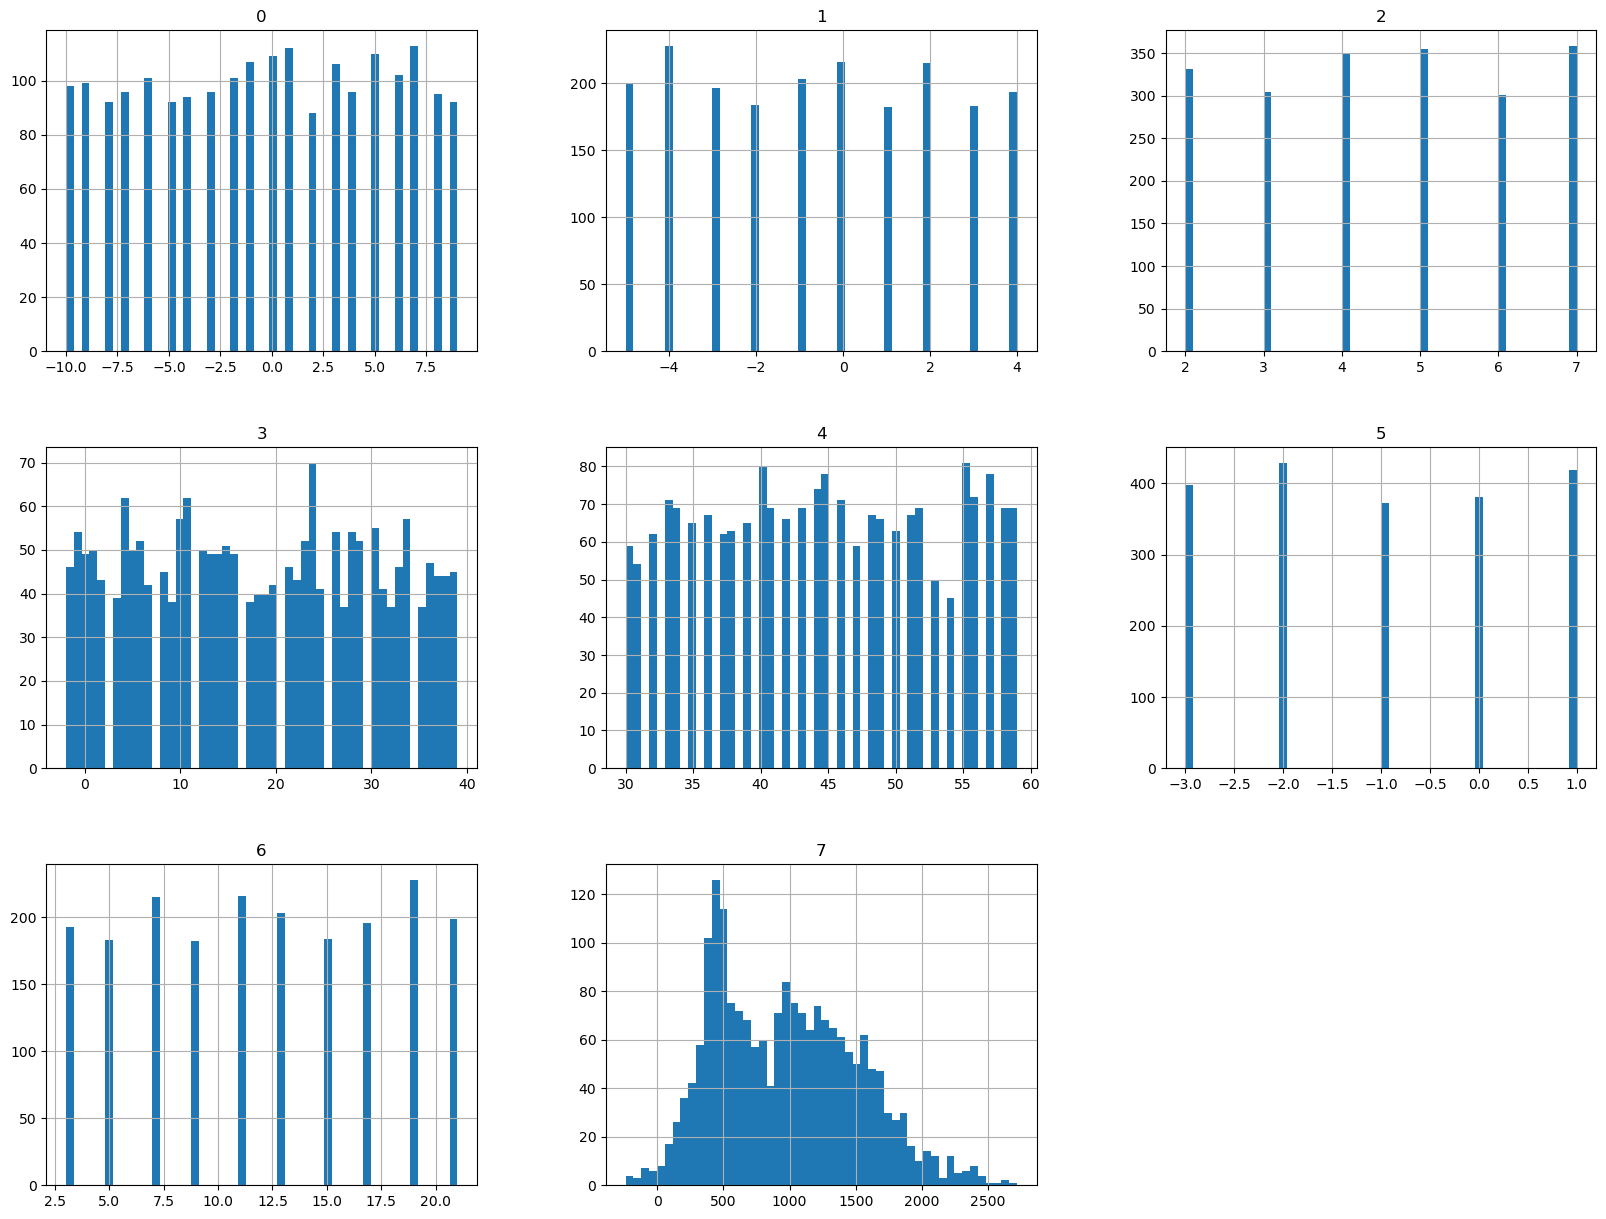

In [15]:
pd.reset_option("display.max_rows")
df.hist(bins=50, figsize=(20, 15))
plt.show()

In [16]:
def preprocess_data(data_matrix):
    mean = np.mean(data_matrix, axis=0)
    std = np.std(data_matrix, axis=0)
    std[std == 0] = 1

    standarized = (data_matrix - mean) / std
    return np.c_[np.ones(standarized.shape[0]), standarized]

In [17]:
def to_matrices(data, labels, preprocess_func=lambda x: x):
    return preprocess_func(data.to_numpy()), labels.to_numpy()


train_matrix, train_labels_matrix = to_matrices(
    train_set, train_labels, preprocess_data
)


print(train_matrix[:6])
print(train_matrix.shape)
print(train_labels_matrix.shape)

[[ 1.          0.93009054 -0.85396457  0.26424844 -0.57262352 -1.56020811
  -0.70065979  0.85396457]
 [ 1.          0.93009054 -0.15275234 -1.48011885  1.59201065 -1.56020811
   1.41522682  0.15275234]
 [ 1.         -1.49686955 -0.15275234  0.26424844 -0.822389   -0.27818258
   0.00463575  0.15275234]
 [ 1.         -0.2833895   0.5484599   0.26424844  0.17667292  1.47003405
   0.70993128 -0.5484599 ]
 [ 1.          1.62350771 -0.85396457 -0.31720732 -0.73913384  1.2369385
  -0.70065979  0.85396457]
 [ 1.          0.58338195 -0.50335845  1.42715997 -1.40517513 -0.86092145
   0.70993128  0.50335845]]
(1065, 8)
(1065,)


In [18]:

validation_matrix, validation_labels_matrix = to_matrices(
    validation_set, validation_labels, preprocess_data
)
test_matrix, test_labels_matrix = to_matrices(test_set, test_labels, preprocess_data)

print(test_matrix.shape, test_labels_matrix.shape)

# test_set

(400, 8) (400,)


# Plot results

In [19]:
def train_and_test(
    model,
    train_matrix,
    train_labels_matrix,
    test_matrix,
    test_labels_matrix,
    epochs_num=700,
):
    loss_at_epochs = [model.test(train_matrix, train_labels_matrix)]
    model.train(epochs_num, train_matrix, train_labels_matrix, loss_at_epochs)
    print(model.test(train_matrix, train_labels_matrix))
    print(model.test(test_matrix, test_labels_matrix))

    plt.plot(range(len(loss_at_epochs)), loss_at_epochs, marker="o", linewidth=0.0025)
    plt.xlabel("Epoch")
    plt.ylabel("MSE loss")
    plt.title("Loss at epochs")
    plt.grid(True)
    plt.show()

# Ordinary model

In [20]:
base_func = OrdinaryBaseFunc(train_matrix.shape[1], train_matrix.shape[0])
loss_func = MSE(train_matrix.shape[0])

model = Model(base_func, loss_func, 0.01)

14781.870256390117
5198.77022319545


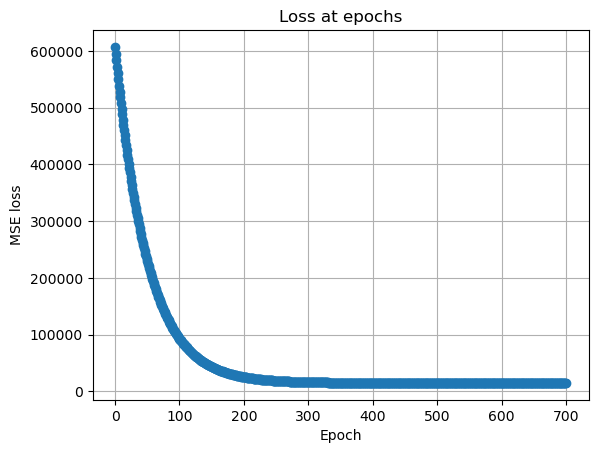

In [21]:
train_and_test(
    model, train_matrix, train_labels_matrix, test_matrix, test_labels_matrix
)

# Ordinary with L2 regularization

In [22]:
base_func_reg_L2 = OrdinaryBaseFunc(train_matrix.shape[1], train_matrix.shape[0])
loss_func_reg_L2 = MSE(train_matrix.shape[0])


model = Model(base_func_reg_L2, loss_func_reg_L2, 0.01, L2_regularization)

14966.813486510759
5250.286244712541


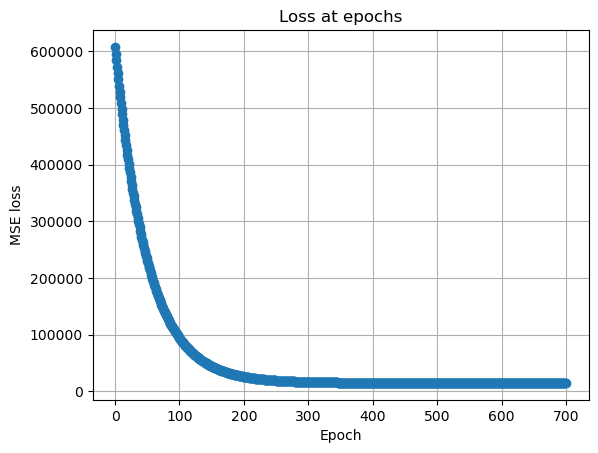

In [23]:
train_and_test(
    model, train_matrix, train_labels_matrix, test_matrix, test_labels_matrix
)

# Ordinary with L1 regularization

In [24]:
lambda_coefficient = 10
base_func_reg_L1 = OrdinaryBaseFunc(train_matrix.shape[1], train_matrix.shape[0])
loss_func_reg_L1 = MSE(train_matrix.shape[0])


model = Model(base_func_reg_L1, loss_func_reg_L1, 0.01, L1_regularization)

14968.841438938576
5214.950002433271


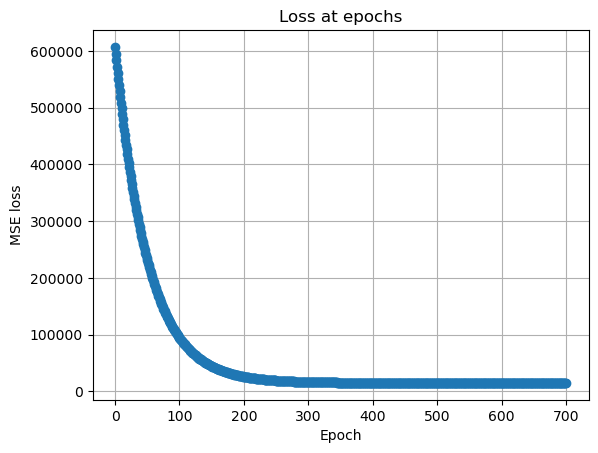

In [25]:
train_and_test(
    model, train_matrix, train_labels_matrix, test_matrix, test_labels_matrix
)

# First Hypothesis

In [26]:
def test_hypothesis(
    preprocess_data_func,
    train_matrix,
    train_labels_matrix,
    validation_matrix,
    validation_labels_matrix,
    test_matrix,
    test_labels_matrix,
):
    train_matrix_hyp = preprocess_data_func(train_matrix)
    validation_matrix_hyp = preprocess_data_func(validation_matrix)
    test_matrix_hyp = preprocess_data_func(test_matrix)
    base_func_hyp = OrdinaryBaseFunc(
        train_matrix_hyp.shape[1], train_matrix_hyp.shape[0]
    )
    loss_func_hyp = MSE(train_matrix_hyp.shape[0])
    model = Model(base_func_hyp, loss_func_hyp, 0.01)

    train_and_test(
        model,
        train_matrix_hyp,
        train_labels_matrix,
        validation_matrix_hyp,
        validation_labels_matrix,
    )

607253.6419338527
313508.4495271378


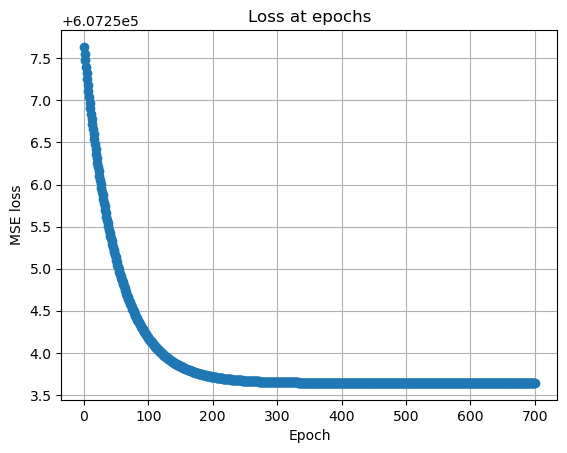

In [27]:
def preprocess_data_matrix_1(data_matrix):
    answer = np.array([])
    answer = np.hstack((answer, data_matrix.T[3]))
    answer = answer.reshape((len(answer), 1))
    # print(answer.shape)
    return answer


test_hypothesis(
    preprocess_data_matrix_1,
    train_matrix,
    train_labels_matrix,
    validation_matrix,
    validation_labels_matrix,
    test_matrix,
    test_labels_matrix,
)

# Second Hypothesis

In [28]:
def preprocess_data_matrix_2(data_matrix):
    answer = np.array([])
    answer = np.hstack((data_matrix.T[3], data_matrix.T[4]))
    print(answer.shape)
    return answer


test_hypothesis(
    preprocess_data_matrix_2,
    train_matrix,
    train_labels_matrix,
    validation_matrix,
    validation_labels_matrix,
    test_matrix,
    test_labels_matrix,
)

(2130,)
(1068,)
(800,)


IndexError: tuple index out of range